# Figure 1d: S3-OIB snow depths


Figure 1a-d illustrate key steps in the NaRRS snow depth and SIT processing chain and are combined with a flow chart to create Figure 1 in the manuscript. 

Here we will plot the spatial distribution of S3-OIB unified dataset snow depths. That is, the OIB snow depths averaged within S3 MWR-defined 23.5 km diameter platelets within a 24 hour cross-over time, as per the manuscript.

**Data required**
* S3-OIB unified dataset found at NaRRS/Data/sentinel3_oib_xo_unified.nc.
* OSI SAF CDR sea ice concentration (OSI-450-a) for the sample dates (for plotting).


1) Import required packages

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import cmocean
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib import gridspec
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature

2) Define functions

In [2]:
def get_cdr_sea_ice_concentation_ds(date, hemisphere):
    """
    Retrieve the OSI SAF CDR or ICDR sea ice concentration dataset for a given date and hemisphere. 
    CDR: OSI-450-a "Sea Ice Concentration Climate Data Record Version 3 (SMMR, SSM/I, and SSMIS) from the EUMETSAT OSI SAF" Doi: 10.15770/EUM_SAF_OSI_0013
    ICDR: OSI-430-a "Interim Sea Ice Concentration Climate Data Record Version 3 from the EUMETSAT OSI SAF" Doi: 10.15770/EUM_SAF_OSI_0014
    
    Parameters:
    date (pd.Timestamp): The date for which to retrieve the dataset.
    hemisphere (str): 'nh' for Northern Hemisphere or 'sh' for Southern Hemisphere.
    
    Returns:
    xr.Dataset: The sea ice concentration dataset for the specified date and hemisphere.
    """
    sic_dir = '/cpnet/li5_userdata/cn/Sentinel3Projects/SIC'
    if date < pd.to_datetime('2021-01-01'):
        target_dir = os.path.join(sic_dir, f"CDR/{date.strftime('%Y/%m')}")
        product_name = f"ice_conc_{hemisphere}_ease2-250_cdr-v3p0_{date.strftime('%Y%m%d1200')}.nc"
    else:
        target_dir = os.path.join(sic_dir, f"ICDR/{date.strftime('%Y/%m')}")
        product_name = f"ice_conc_{hemisphere}_ease2-250_icdr-v3p0_{date.strftime('%Y%m%d1200')}.nc"
    return xr.open_dataset(os.path.join(target_dir, product_name))

#========================================================================================================================#

def set_axis_boundary_circular(ax):
    """
    Set the boundary of a matplotlib axis to be circular inplace.
    
    Parameters:
    ax (matplotlib.axes.Axes): The axis to set the boundary for.
    """
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

1) Load the S3-OIB unified dataset

In [3]:
#open the overlap dataset
overlap_ds = xr.open_dataset(f'../Data/sentinel3_oib_xo_unified.nc')

2) Apply quality control filters as described in the manuscript

In [5]:
#filter out samples with ice concentration below 75% 
min_sic = 75
overlap_ds = overlap_ds.where(overlap_ds['ice_conc_01'] >= min_sic, drop=True)

#reduce to relevant variables and drop nans
coord_subset = [f'time_01', f'xc_01', f'yc_01', f'lon_01', f'lat_01']
feature_subset = ['gradient_ratio_corrected_01',
                    'leading_edge_width_mean_01',
                    'trailing_edge_decay_mean_01',]
waveform_feature_count_vars = [feature.replace('_mean_01', '_count_01') for feature in feature_subset if 'mean' in feature]

df = overlap_ds.to_dataframe().reset_index()[coord_subset+feature_subset+waveform_feature_count_vars+['mean_snow_depth_01', 'sitype_osisaf_01']]
df = df.dropna().reset_index(drop=True)

#filter out samples with less than minimum waveform feature counts
min_wf_count = 15
for feature in waveform_feature_count_vars:
    df = df.where(df[feature] >= min_wf_count).dropna().reset_index(drop=True)

3) Get the average sea ice concentration for the sample dates

In [6]:
#we'll plot the data points over a sea ice concentration map
#get the average sea ice concentration map for the dates of our samples
hemisphere = 'nh'
sic_ds = []
for date in df['time_01'].dt.date:
    daily_sic_ds = get_cdr_sea_ice_concentation_ds(pd.to_datetime(date), hemisphere)
    sic_ds.append(daily_sic_ds)
sic_ds = xr.concat(sic_ds, dim='time')
avg_sic = sic_ds['ice_conc'].mean(dim='time') #note the concentration is weighted towards the dates with more samples

4) Map the S3-OIB snow depths 

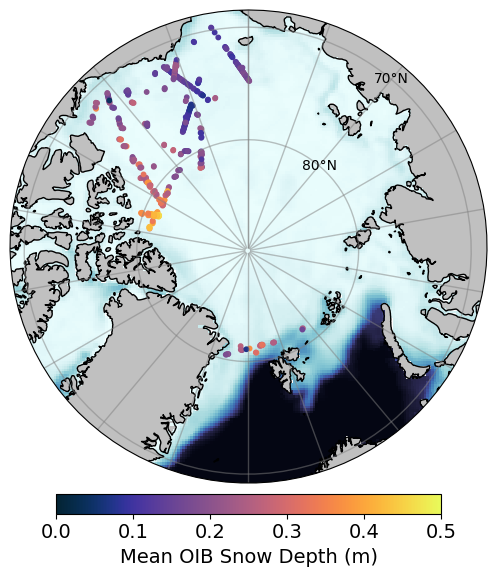

In [7]:

fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=-0)})
ax.set_extent([-180, 180, 68.5, 90], ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, color='silver')
set_axis_boundary_circular(ax)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, dms=True, x_inline=True, y_inline=True, zorder=0)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 20))
gl.ylocator = mticker.FixedLocator(np.arange(60, 91, 10))
ax.pcolormesh(avg_sic['lon'], avg_sic['lat'], avg_sic, cmap=cmocean.cm.ice, vmin=0, vmax=100, transform=ccrs.PlateCarree(), zorder=-1)
snod_scatter = ax.scatter(df['xc_01'], df['yc_01'], c=df['mean_snow_depth_01'], s=10, transform=ccrs.epsg(6931), vmin=0, vmax=0.5, cmap=cmocean.cm.thermal)
snow_cbar = plt.colorbar(snod_scatter, ax=ax, label='Mean OIB Snow Depth (m)', orientation='horizontal', pad=0.02, shrink=0.5)
snow_cbar.ax.tick_params(labelsize=14)
snow_cbar.set_label('Mean OIB Snow Depth (m)', fontsize=14)
snow_cbar.set_ticks(np.arange(0, 0.6, 0.1))
plt.tight_layout()
plt.savefig(f'S3_OIB_unified_OIB_snow_depth.png', dpi=300)
plt.show()
